# Bar Traveling Salesman Problem in Marseille

In this notebook we explore the case of the _Travelling Salesman Problem_ (TSP).

This problem has been applied to finding the shortest route between bars and pubs in UK. See article [here](https://www.math.uwaterloo.ca/tsp/uk/).

See also CACM article [here](https://cacm.acm.org/news/97397-p-np-its-bad-news-for-the-power-of-computing/fulltext).

Process:
* List of bars is collected from French INSEE Sirene database.
* GPS position is collected from OpenStreetMap using addresses from previous step.
* TSP 2 Opt algorithm is used to find the best route.
* Folium is used to display bars locations and the optimal route.

Below an illustration from the original article with UK bars & pubs.

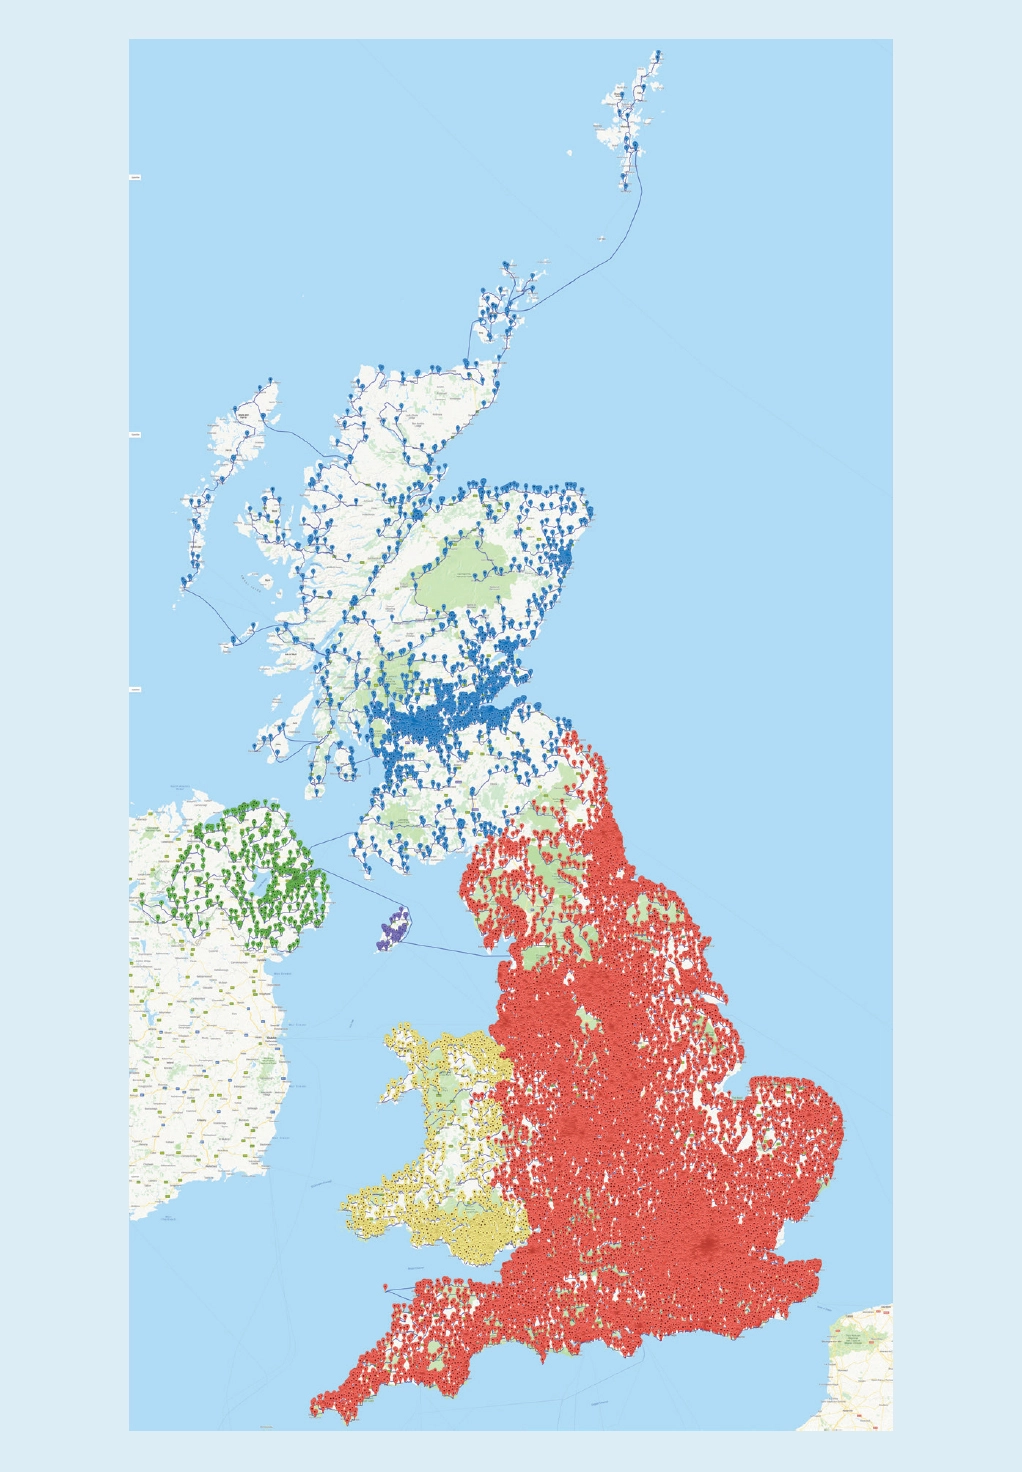

## Installs 📦

In [1]:
# Folium for maps
# Geopy for Nominatim --> OpenStreetMap
!pip install folium
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download data from repo 📁

In [2]:
!curl -O https://raw.githubusercontent.com/HerveMignot/bar_tsp/main/data/etablissements_13000.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56699  100 56699    0     0   236k      0 --:--:-- --:--:-- --:--:--  236k


In [6]:
!curl -O https://raw.githubusercontent.com/HerveMignot/bar_tsp/main/data/processed/bars_13000_771.parquet
!curl -O https://raw.githubusercontent.com/HerveMignot/bar_tsp/main/data/processed/route_bars_13000_771.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64714  100 64714    0     0   371k      0 --:--:-- --:--:-- --:--:--  371k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5742  100  5742    0     0  28425      0 --:--:-- --:--:-- --:--:-- 28425


## Imports

In [3]:
import pathlib

import folium

import numpy as np
import pandas as pd

## Constants

In [7]:
SAVE_PATH = pathlib.Path('./')
BARS_SAVE_FILE = 'bars_13000_771.parquet'
BEST_ROUTE_SAVE_FILE = 'route_bars_13000_771.parquet'

## Loading data

Bars are collected from Sirene.fr

APE Activity code: 56.30Z (_débit de boissons_).

We only keep name and address fields.

Special extraction can be done [here](http://sirene.fr/sirene/public/creation-fichier).

In [8]:
USED_COLS = [
    'denominationUniteLegale', 'sigleUniteLegale', 'denominationUsuelle1UniteLegale',
    'complementAdresseEtablissement', 'numeroVoieEtablissement', 'indiceRepetitionEtablissement', 'typeVoieEtablissement', 'libelleVoieEtablissement',
    'codePostalEtablissement', 'libelleCommuneEtablissement',
    'enseigne1Etablissement']

bar_df = pd.read_csv('etablissements_13000.csv.gz', dtype={'numeroVoieEtablissement': str, 'codePostalEtablissement': str})[USED_COLS]

### Checking missing values & data types

In [9]:
bar_df.isna().sum()

denominationUniteLegale            241
sigleUniteLegale                   934
denominationUsuelle1UniteLegale    741
complementAdresseEtablissement     867
numeroVoieEtablissement             16
indiceRepetitionEtablissement      932
typeVoieEtablissement               26
libelleVoieEtablissement             0
codePostalEtablissement              0
libelleCommuneEtablissement          0
enseigne1Etablissement             520
dtype: int64

In [10]:
#bar_df.fillna('').applymap(type).apply(pd.Series.value_counts).transpose()
bar_df.applymap(type).apply(pd.Series.value_counts).transpose()

,<class 'str'>,<class 'float'>
denominationUniteLegale,704.0,241.0
sigleUniteLegale,11.0,934.0
denominationUsuelle1UniteLegale,204.0,741.0
complementAdresseEtablissement,78.0,867.0
numeroVoieEtablissement,929.0,16.0
indiceRepetitionEtablissement,13.0,932.0
typeVoieEtablissement,919.0,26.0
libelleVoieEtablissement,945.0,NaN
codePostalEtablissement,945.0,NaN
libelleCommuneEtablissement,945.0,NaN


### Building full address field

In [11]:
ADDRESS_FIELD = 'address'

bar_df[ADDRESS_FIELD] = (lambda df: df['complementAdresseEtablissement'] + ' ' + df['numeroVoieEtablissement'] + ' ' + df['indiceRepetitionEtablissement']
                                    + ' ' + df['typeVoieEtablissement'] + ' ' + df['libelleVoieEtablissement']
                                    + ', ' + df['codePostalEtablissement'] + ' ' + df['libelleCommuneEtablissement'].str.split(' ').str[0] + ', FRANCE')(bar_df.fillna(''))

In [12]:
bar_df[ADDRESS_FIELD]

0          2  RUE SAINT SAENS, 13001 MARSEILLE, FRANCE
1            7  PL AUX HUILES, 13001 MARSEILLE, FRANCE
2        58  BD DE SAINT LOUP, 13010 MARSEILLE, FRANCE
3           95   LA CANEBIERE, 13001 MARSEILLE, FRANCE
4       5  RUE DES RECOLETTES, 13001 MARSEILLE, FRANCE
                            ...                       
940            1  RUE COLBERT, 13001 MARSEILLE, FRANCE
941     189  RUE SAINT PIERRE, 13005 MARSEILLE, FRANCE
942         154  CRS LIEUTAUD, 13006 MARSEILLE, FRANCE
943         60  RUE D AUBAGNE, 13001 MARSEILLE, FRANCE
944      71  AV DE ST ANTOINE, 13015 MARSEILLE, FRANCE
Name: address, Length: 945, dtype: object

## Geocoding address

Using OpenStreetMap service, we get GPS position of the addresses.

In [13]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent="MarseilleTSP")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# For testing
#bar_df.head(20)[ADDRESS_FIELD].apply(geocode)

In [ ]:
%%time
bar_df['location'] = bar_df[ADDRESS_FIELD].apply(geocode)

In [33]:
bar_df.head(10)[['denominationUniteLegale', 'sigleUniteLegale', 'denominationUsuelle1UniteLegale', ADDRESS_FIELD]]

,denominationUniteLegale,sigleUniteLegale,denominationUsuelle1UniteLegale,address
0,BAR AMERICAIN LE PARADOU,NaN,NaN,"2 RUE SAINT SAENS, 13001 MARSEILLE, FRANCE"
1,LA TARTANE,NaN,L'INTERIEUR,"7 PL AUX HUILES, 13001 MARSEILLE, FRANCE"
2,SNC GREGORY,NaN,NaN,"58 BD DE SAINT LOUP, 13010 MARSEILLE, FRANCE"
3,REX,NaN,LE TRAMWAY,"95 LA CANEBIERE, 13001 MARSEILLE, FRANCE"
4,SARL O MONACO,NaN,O MONACO,"5 RUE DES RECOLETTES, 13001 MARSEILLE, FRANCE"
5,FERRATO CIE VINS DEMI GROS DET,NaN,NaN,"15 A RUE ANTOINE MAILLE, 13005 MARSEILLE, FRANCE"
6,BEAUSEJOUR BAR,NaN,NaN,"50 RUE BRANDIS, 13005 MARSEILLE, FRANCE"
7,SNC BAR-TABAC DE PONT-DE-VIVAUX,NaN,NaN,"7 BD DE PONT DE VIVAUX, 13010 MARSEILLE, FRANCE"
8,BAR DEGUSTATION,NaN,LE BABYLONE,"87 RUE DE LA REPUBLIQUE, 13002 MARSEILLE, FR..."
9,NaN,NaN,BAR DANCING DE LA PLAGE,"91 PRO GEORGES POMPIDOU, 13008 MARSEILLE, FR..."


Number of location found and percentage.

In [ ]:
bar_df['location'].notnull().sum(), bar_df['location'].notnull().sum() / bar_df['location'].shape[0]

### Extracting latitude & longitude from location

In [22]:
bar_df['latitude'] = bar_df['location'].apply(lambda r: None if r is None else r.latitude)
bar_df['longitude'] = bar_df['location'].apply(lambda r: None if r is None else r.longitude)

In [23]:
# Save to a file to geocoding time
bar_df.drop(columns=['location']).to_parquet(SAVE_PATH / BARS_SAVE_FILE)

### Reload geocoded data to avoid rerun

In [17]:
!curl -O https://raw.githubusercontent.com/HerveMignot/bar_tsp/main/data/processed/bars_13000_771.parquet
bar_df = pd.read_parquet('bars_13000_771.parquet')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64714  100 64714    0     0  1504k      0 --:--:-- --:--:-- --:--:-- 1504k


## Draw maps 🧭

### Map of bars without route

In [18]:
bar_map = folium.Map(
    location=[43.30, 5.40],
    tiles='cartodbpositron',
    zoom_start=11.6,
    width=1000,
    height=600,
)
bar_df.dropna(subset=['latitude', 'longitude']).apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(bar_map), axis=1)
bar_map

### Define 2 opt function

In [19]:
# From https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy

# Calculate the euclidian distance in n-space of the route r traversing places c, ending at the path start.
path_distance = lambda r, c: np.sum([np.linalg.norm(c[r[p]] - c[r[p-1]]) for p in range(len(r))])

# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r, i, k: np.concatenate((r[0:i], r[k:-len(r)+i-1:-1], r[k+1:len(r)]))

def two_opt(nodes, improvement_threshold=0.001, save_steps=False):
  """2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt
  """
  # Make an array of row numbers corresponding to nodes.
  route = np.arange(nodes.shape[0])
  steps = []

  # Improvement factor explanation
  improvement_factor = 1

  # Best distance will hold best distance so far
  # Initialized with current route
  best_distance = path_distance(route, nodes)
  if save_steps:
    steps.append((best_distance, route))

  # Iterations will run until no significant improvement
  # improvement_threshold is the % of improvement
  while improvement_factor > improvement_threshold:
    distance_to_beat = best_distance # Record the distance at the beginning of the loop.
    
    for swap_first in range(1, len(route)-2): # From each node except the first and last,
      for swap_last in range(swap_first+1, len(route)): # to each of the nodes following,
        new_route = two_opt_swap(route, swap_first, swap_last) # try reversing the order of these nodes
        new_distance = path_distance(new_route, nodes) # and check the total distance with this modification.
        if new_distance < best_distance: # If the path distance is an improvement,
          route = new_route # make this the accepted best route
          best_distance = new_distance # and update the distance corresponding to this route.
          if save_steps:
            steps.append((best_distance, route))
    improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
  
  return route if not save_steps else (route, steps)


### Build bars position array

In [20]:
# Build an array of 2-dim with latitude & longitude
bars = bar_df.dropna(subset=['latitude', 'longitude'])[['latitude', 'longitude']].to_numpy()

### Run optimization

In [42]:
%%time
route = two_opt(bars, 0.001)
pd.DataFrame(route, columns=['nodes']).to_parquet(SAVE_PATH / BEST_ROUTE_SAVE_FILE)

CPU times: user 2h 53min 1s, sys: 5min 35s, total: 2h 58min 36s
Wall time: 2h 53min 15s


In [96]:
!curl -O https://raw.githubusercontent.com/HerveMignot/bar_tsp/main/data/processed/route_bars_13000_771.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5742  100  5742    0     0  44511      0 --:--:-- --:--:-- --:--:-- 44511


In [97]:
route = pd.read_parquet(SAVE_PATH / BEST_ROUTE_SAVE_FILE)['nodes'].to_list()

In [98]:
assert len(route) == bar_df.dropna(subset=['latitude', 'longitude']).shape[0], "Route file has not same number of nodes than bars file"

### Maps of bars with route

In [95]:
route_map = folium.Map(
    location=[43.33, 5.40],
    tiles='cartodbpositron',
    zoom_start=12,
    width=1000,
    height=650,
)

bar_df.dropna(subset=['latitude', 'longitude']).apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(route_map), axis=1)

loc = np.array([bars[route[i]] for i in range(len(route))])

folium.PolyLine(loc,
                color='red',
                weight=4,
                opacity=0.8).add_to(route_map)
route_map

## Measuring size effect on execution ⏲

Chart below gives execution times depending on the number of nodes (bars) considered when computing the optimal route.

In [ ]:
import time

SIZES = [50, 100, 200, 300, 400, 500, 600, 700]
execution_times = []

for size in SIZES:
  _bars = bar_df.sample(n=size).dropna(subset=['latitude', 'longitude'])[['latitude', 'longitude']].to_numpy()
  start_time = time.time()
  _ = two_opt(_bars)
  end_time = time.time()
  execution_times.append((size, end_time - start_time))

pd.DataFrame(data=execution_times, columns=['n', 'time']).to_parquet(SAVE_PATH / 'execution_times.parquet')
pd.DataFrame(data=execution_times, columns=['n', 'time']).set_index('n').plot.line();

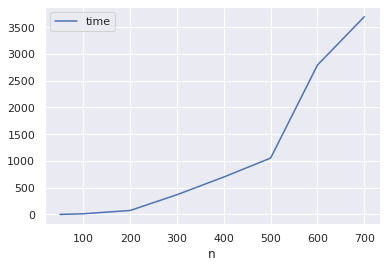

In [3]:
import seaborn as sns

sns.set()
pd.read_parquet(SAVE_PATH / 'execution_times.parquet').set_index('n').plot.line();